# Import Dependencies

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
from tqdm import tqdm
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch import optim
import time
from torch.autograd import Variable
%matplotlib inline

In [2]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Load Data

In [3]:
data_dir = "mliii-assignment2" # Path to data directory
labels = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
assert(len(os.listdir(os.path.join(data_dir, 'train'))) == len(labels))

In [4]:
le = LabelEncoder()
labels.breed = le.fit_transform(labels.breed)
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,19
1,001513dfcb2ffafc82cccf4d8bbaba97,37
2,001cdf01b096e06d78e9e5112d419397,85
3,00214f311d5d2247d5dfe4fe24b2303d,15
4,0021f9ceb3235effd7fcde7f7538ed62,49


In [5]:
X = labels.id
y = labels.breed

X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.4, random_state=SEED, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=SEED, stratify=y_valid)

In [6]:
class Dataset_Interpreter(Dataset):
    def __init__(self, data_path, file_names, labels=None, transforms=None):
        self.data_path = data_path
        self.file_names = file_names
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return (len(self.file_names))
    
    def __getitem__(self, idx):
        img_name = f'{self.file_names.iloc[idx]}.jpg'
        full_address = os.path.join(self.data_path, img_name)
        image = Image.open(full_address)
        label = self.labels.iloc[idx]
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        return np.array(image), label

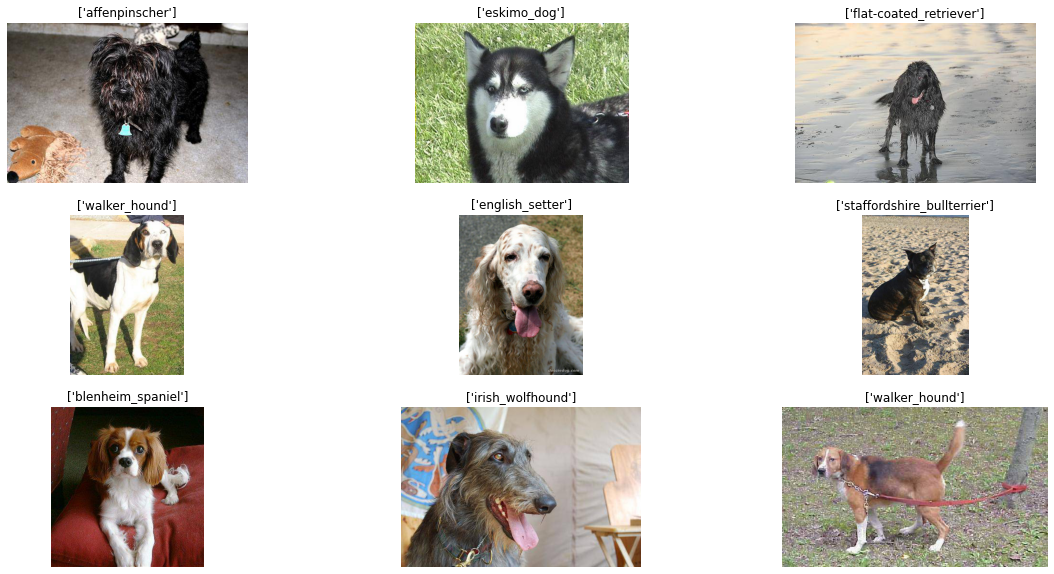

In [8]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20,10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(f'{le.inverse_transform([images[i][1]])}')
        ax.imshow(np.array(images[i][0]))
        ax.axis('off')
N_IMAGES = 9

train_data = Dataset_Interpreter(data_path=data_dir+'/train/', file_names=X_train, labels=y_train)
images = [(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]] 
plot_images(images)

# Create Model

In [ ]:
# Create model here 

# Submission CSV

In [ ]:
import pandas as pd

def generate_submission(predictions, sample_submission_path, output_path):
    """
    Generate a Kaggle submission file based on the given predictions.

    Parameters:
    - predictions: A dictionary with image ids as keys and a list of 120 probabilities as values.
    - sample_submission_path: Path to the provided sample submission file.
    - output_path: Path to save the generated submission file.
    """
    # Load the sample submission
    sample_submission = pd.read_csv(sample_submission_path)
    
    # Replace the sample probabilities with the actual predictions
    for image_id, probs in predictions.items():
        sample_submission.loc[sample_submission['id'] == image_id, sample_submission.columns[1:]] = probs

    # Save the modified sample submission as the final submission
    sample_submission.to_csv(output_path, index=False)

# Example usage
predictions = {
    '000621fb3cbb32d8935728e48679680e': [0.01, 0.02, ...],  # Replace with actual probabilities
    # ... add more predictions
}
generate_submission(predictions, data_dir + '/sample_submission.csv', 'my_submission.csv')